In [1]:
# Gaussian Regression Experiement
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C  
from sklearn.metrics import mean_squared_error

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../lib")))

from data_load import load_data
from validation import rmse_validation, mae_validation, r2_validation

In [4]:
# Load data
date_start = pd.to_datetime("2025-04-13 12:00:00 AM")
date_end = pd.to_datetime("2025-04-27 12:00:00 AM")
T = 24 * 60

all_data = load_data(date_start=date_start, date_end=date_end)
garages = [x + " Garage" for x in ["North", "South", "West", "South Campus"]]

In [5]:
# Define kernel parameters (similar to initial_guess)
kernel_params = {
    'constant_value': 1.0,
    'constant_bounds': (1e-3, 1e3),
    'length_scale': 10,
    'length_scale_bounds': (1e-2, 1e2)
}


Processing North Garage...
Fitted Gaussian Process parameters:
31.6**2 * RBF(length_scale=55.9)


/Users/fardinhaque/Downloads/Coding_Projects/ParkPredict/ParkPredict_Experiments/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


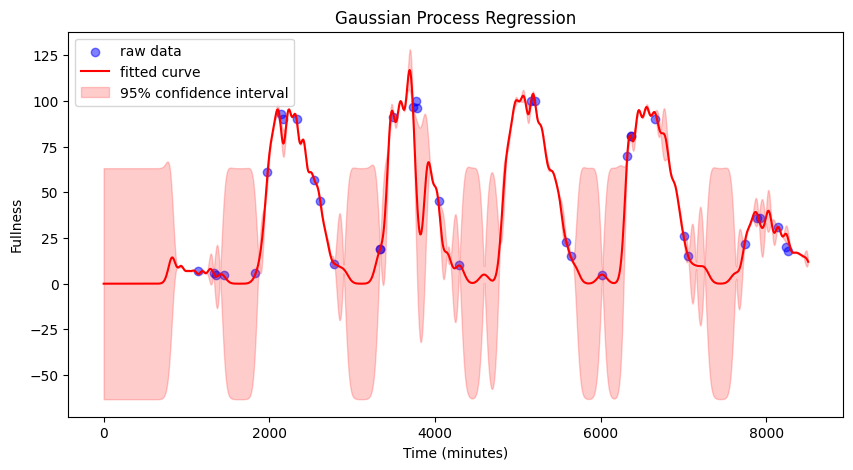


Metrics for North Garage:
RMSE: 11.422014348355027
MAE: 4.323958880937555
R²: 0.8957634689754853

Processing South Garage...


/Users/fardinhaque/Downloads/Coding_Projects/ParkPredict/ParkPredict_Experiments/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Fitted Gaussian Process parameters:
31.6**2 * RBF(length_scale=56.3)


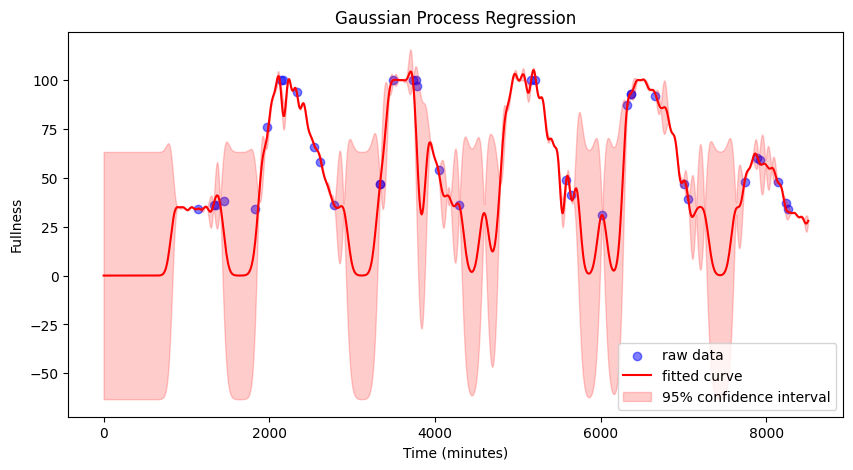


Metrics for South Garage:
RMSE: 8.91507830222079
MAE: 4.070491096693457
R²: 0.8844836541699834

Processing West Garage...
Fitted Gaussian Process parameters:
31.6**2 * RBF(length_scale=54.1)


/Users/fardinhaque/Downloads/Coding_Projects/ParkPredict/ParkPredict_Experiments/venv/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


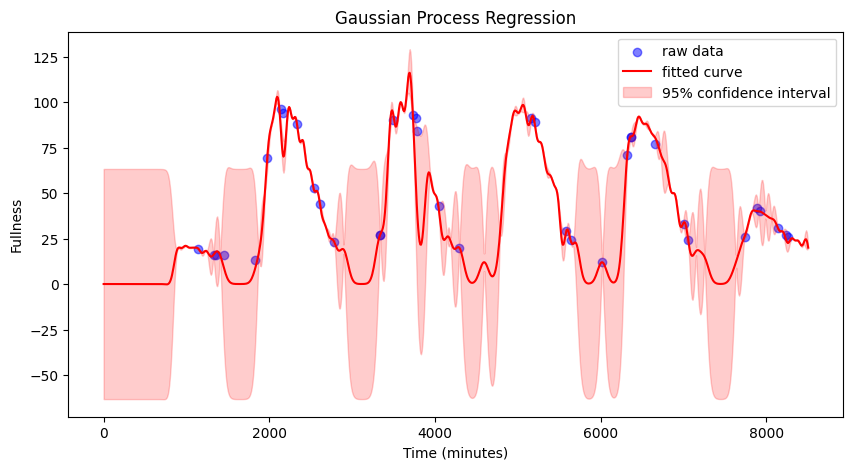


Metrics for West Garage:
RMSE: 10.771335910002692
MAE: 4.429153714181501
R²: 0.8688517247091987

Processing South Campus Garage...
Fitted Gaussian Process parameters:
6.2**2 * RBF(length_scale=43.4)


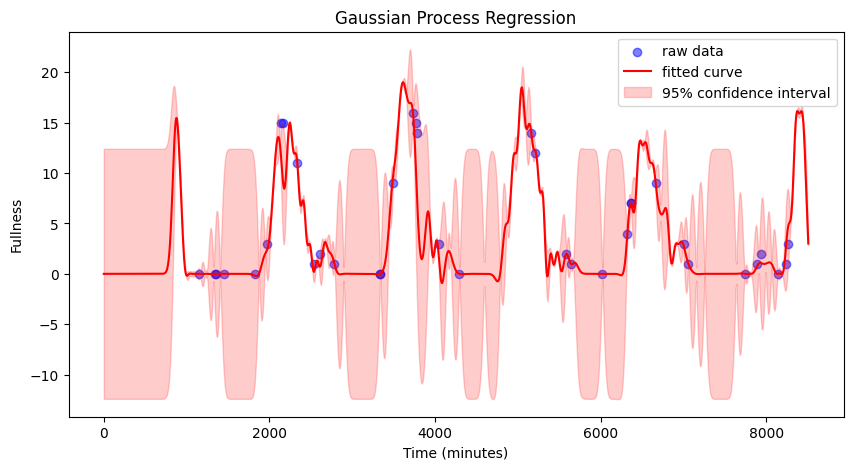


Metrics for South Campus Garage:
RMSE: 1.928888027203878
MAE: 0.8775473364819206
R²: 0.8769147515726535


In [6]:
def gaussian_fit(data):
    # Extract x and y
    x_data = (data['timestamp'] - date_start).dt.total_seconds() / 60
    y_data = data['fullness']
    
    # Reshape for sklearn
    X = x_data.values.reshape(-1, 1)
    y = y_data.values
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Create kernel and fit
    kernel = C(kernel_params['constant_value'], kernel_params['constant_bounds']) * \
             RBF(kernel_params['length_scale'], kernel_params['length_scale_bounds'])
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)
    gp.fit(X_train, y_train)
    
    # Predict
    y_pred, sigma = gp.predict(X_test, return_std=True)
    
    # Generate points for smooth curve
    x_end = int(x_data.tail(1).values[0])
    all_x_vals = np.linspace(0, x_end, num=1000).reshape(-1, 1)
    all_y_pred, all_sigma = gp.predict(all_x_vals, return_std=True)
    
    print("Fitted Gaussian Process parameters:")
    print(gp.kernel_)
    
    return X_test, all_x_vals, y_test, y_pred, all_y_pred, sigma, all_sigma

def model_plot(x_test, all_x_vals, y_test, y_pred, all_y_pred, sigma, all_sigma):
    plt.figure(figsize=(10, 5))
    plt.scatter(x_test, y_test, color='blue', alpha=0.5, label='raw data')
    plt.plot(all_x_vals, all_y_pred, color='red', label='fitted curve')
    plt.fill_between(all_x_vals.flatten(), 
                    all_y_pred - 2*all_sigma, 
                    all_y_pred + 2*all_sigma, 
                    color='red', alpha=0.2, 
                    label='95% confidence interval')
    plt.xlabel('Time (minutes)')
    plt.ylabel('Fullness')
    plt.title('Gaussian Process Regression')
    plt.legend()
    plt.show()


# Process each garage
for garage in garages:
    print(f"\nProcessing {garage}...")
    garage_data = all_data[all_data['garage name'] == garage]
    
    # Fit and plot
    fit_params = gaussian_fit(garage_data)
    model_plot(*fit_params)
    
    # Calculate metrics
    y_test = fit_params[2]  # This is y_test
    y_pred = fit_params[3]  # This is y_pred
    
    rmse = rmse_validation(y_test, y_pred)
    mae = mae_validation(y_test, y_pred)
    r2 = r2_validation(y_test, y_pred)
    
    print(f"\nMetrics for {garage}:")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R²: {r2}")